# **Ranking Inclusion Model**

In [1]:
import pandas as pd
import numpy as np
import os 
from os import listdir
from os.path import isfile, join, isdir, split
#import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_theme()
os_path=os.getcwd()
import matplotlib.pyplot as plt

#BERT and SciBERT
import transformers
from transformers import AutoModel, BertTokenizerFast, BertModel, BertTokenizer

#PyTorch
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#datetime
import time
import datetime

In [2]:
os_path

'C:\\Users\\sbyli\\Documents\\USAID\\articles_processing\\notebooks\\for training'

## Import classifier data

In [5]:
# file_path= '../../tmp/outputs/combined SR and IE data.xlsx'
file_path= '../../tmp/EGM_Ag/inputs/SR/Step4 - HIC.xlsx'
# file_path= '../../tmp/outputs/combined IE data.xlsx'
data = pd.read_excel(file_path, engine='openpyxl')

# # file_path= '../tmp/outputs/Classifier reports edited_cleaned.xlsx'
# egm_name= 'EGM_Nutrition'
# file_path= '../tmp/{}/inputs/Document X_Nutrition_V1.1.xlsx'.format(egm_name)
# data1=pd.read_excel(file_path, sheet_name= 'Sheet 1', engine='openpyxl')
# data1 = data1[0:5000]

In [6]:
# data = data[0:53532]
# data

In [7]:
data.columns

Index(['Batch', 'Item ID', 'Short Title', 'title', 'year', 'abstract',
       'Decision', 'cleaned text', 'Include', 'countries_mentioned',
       'country_codes', 'provinces', 'districts', 'geo_regions',
       'world_bankdivision_regions', 'keywords_study_type', 'study_type',
       'LMIC (LL)'],
      dtype='object')

## Train-test-val split

In [20]:
data = data.astype({"cleaned text": str})
datax = data

# datax = data[data['SR'] == 1]
# datax = data[data['SR'] == 0]

train_text = datax['cleaned text']
train_labels = datax['Include']

from sklearn.model_selection import train_test_split
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train_labels)

val_text, test_text, val_labels, test_labels = train_test_split(val_text, val_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.5, 
                                                                    stratify=val_labels)

In [21]:
all_text=data['cleaned text']
all_labels=data['Include']

## Import BERT and SciBERT

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

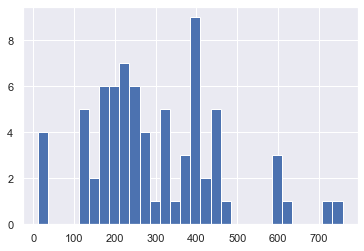

In [22]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# SciBERT
# bert = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# sciBERT
# tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

##Tokenize the Sentences
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [23]:
type(seq_len)
sum(seq_len)/len(seq_len)

298.1506849315069

## Get text embeddings using BERT or SciBERT

In [24]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 360,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 360,
    padding='max_length',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 360,
    padding='max_length',
    truncation=True
)

## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist(), dtype=torch.long)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist(), dtype=torch.long)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist(), dtype=torch.long)

## Get tokens for all data

In [25]:
# all_text = data[data['SR'] == 0]['cleaned text']
# all_labels = data[data['SR'] == 0]['Include']

tokens_all= tokenizer.batch_encode_plus(
    all_text.tolist(),
    max_length = 360,
    # max_length = 40,
    padding='max_length',
    truncation=True
)


all_seq = torch.tensor(tokens_all['input_ids'])
all_mask = torch.tensor(tokens_all['attention_mask'])
all_y = torch.tensor(all_labels.tolist(), dtype=torch.long)

In [26]:
#to handle the imbalanced datasets for classification:
#https://towardsdatascience.com/guide-to-classification-on-imbalanced-datasets-d6653aa5fa23
#https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4
#https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classi fication/

# example of random oversampling to balance the class distribution
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import ClusterCentroids
# summarize class distribution
print(Counter(train_labels))
# define oversampling strategy (Different approaches)
# oversample = RandomOverSampler(sampling_strategy='minority')
oversample = SMOTE(sampling_strategy = 1)
# undersample = ClusterCentroids(random_state=42)
# fit and apply the transform
X = train_seq.numpy()
Z = train_mask.numpy()
A = np.zeros((len(train_y),720))
for i in range(0,len(train_y)):
    A[i,0:360] = X[i]
    A[i,360:720] = Z[i]
X_over, y_over = oversample.fit_resample(A, train_y.numpy())
# X_over, y_over = undersample.fit_resample(A, train_y.numpy())

# summarize class distribution
print(Counter(y_over))
# X_seq = np.zeros((70294,360))
# X_mask = np.zeros((70294,360))
# for i in range(0,70294):
X_seq = np.zeros((max(list(Counter(train_labels).values()))*2,360))
X_mask = np.zeros((max(list(Counter(train_labels).values()))*2,360))
for i in range(0,max(list(Counter(train_labels).values()))*2):
    X_seq[i] = X_over[i,0:360]
    X_mask[i] = X_over[i,360:720]

train_seq = torch.tensor(X_seq, dtype=torch.long)
train_mask = torch.tensor(X_mask, dtype=torch.long)
train_y = torch.tensor(y_over, dtype=torch.long)

Counter({1: 38, 0: 35})
Counter({0: 38, 1: 38})


In [27]:
# train_seq.shape[0]+test_seq.shape[0]+val_seq.shape[0]
train_seq.shape[0]+test_seq.shape[0]

92

In [28]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, 
        sampler = val_sampler, 
        batch_size=batch_size
        )

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, 
                                   sampler=test_sampler, 
                                   batch_size=batch_size
                                  )

validation_dataloader = DataLoader(
            val_data, # The validation samples.
            sampler = SequentialSampler(val_data), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [105]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [106]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:40]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-20:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# # freeze all the parameters
# for param in bert.parameters():
#     param.requires_grad = False

i = 0
for param in model.parameters():
    param.requires_grad = False
    i += 1
    if i == 180:
        break

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)
bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.layer.0.att

In [107]:
lr = 10e-6
optimizer = AdamW(model.parameters(),
#                   lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  lr = lr,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [108]:
from transformers import get_linear_schedule_with_warmup
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 100

# set initial loss to infinite
best_train_loss = float('inf')

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [109]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

### Helper function fo formating elapsed time as hh:mm:ss

In [110]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Train the model

In [111]:
# model state_dict

# model1 = BertForSequenceClassification(*args, **kwargs)
# model1.load_state_dict(torch.load(PATH))
# model1.eval()

In [112]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 200

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []
best_test_loss = 10

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of training sentences, and
        # accumulate it over all batches.
        total_train_accuracy += flat_accuracy(logits, label_ids)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader) 

    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("  Accuracy: {0:.5f}".format(avg_train_accuracy))
    
#     #save the best model
#     if avg_train_loss < best_train_loss:
#         best_train_loss = avg_train_loss
#         PATH= 'classifier_model_state_dict_1000.pth'
#         model_path='classifier_model_cleaned_1000.pth'

#         torch.save(model.state_dict(), PATH)
#         torch.save(model, model_path)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.5f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.5f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # ========================================
    #              Test
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Testing...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_test_accuracy = 0
    total_test_loss = 0
    nb_test_steps = 0
    a = 0
    # Evaluate data for one epoch
    for batch in test_dataloader:
        if a == 0:
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels,
                               return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits

            # Accumulate the validation loss.
            total_test_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_test_accuracy += flat_accuracy(logits, label_ids)
        
    # Report the final accuracy for this validation run.
    avg_test_accuracy = total_test_accuracy / len(test_dataloader)
#     avg_test_accuracy = total_test_accuracy / a
    print("  Accuracy: {0:.5f}".format(avg_test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.5f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    #save the best model
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        model_path='classifier_IE_'+str(lr)+'.pth'
        
        torch.save(model, model_path)

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur.': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Test Loss': avg_test_loss,
            'Test Accur.': avg_test_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time,
            'Test Time': test_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 100 ========
Training...
  Accuracy: 0.51250

  Average training loss: 0.78779
  Training epcoh took: 0:00:01

Running Validation...
  Accuracy: 0.50000
  Validation Loss: 0.75554
  Validation took: 0:00:00

Running Testing...
  Accuracy: 0.56250
  Test Loss: 0.68655
  Test took: 0:00:00

======== Epoch 2 / 100 ========
Training...
  Accuracy: 0.52917

  Average training loss: 0.70315
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.62500
  Validation Loss: 0.67856
  Validation took: 0:00:00

Running Testing...
  Accuracy: 0.62500
  Test Loss: 0.62042
  Test took: 0:00:00

======== Epoch 3 / 100 ========
Training...
  Accuracy: 0.61667

  Average training loss: 0.64902
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.68750
  Validation Loss: 0.63011
  Validation took: 0:00:00

Running Testing...
  Accuracy: 0.68750
  Test Loss: 0.57253
  Test took: 0:00:00

======== Epoch 4 / 100 ========
Training...
  Accuracy: 0.67500

  Avera


======== Epoch 28 / 100 ========
Training...
  Accuracy: 0.97083

  Average training loss: 0.13758
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.87500
  Validation Loss: 0.26130
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.07389
  Test took: 0:00:00

======== Epoch 29 / 100 ========
Training...
  Accuracy: 0.97500

  Average training loss: 0.15153
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.87500
  Validation Loss: 0.25375
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.06864
  Test took: 0:00:00

======== Epoch 30 / 100 ========
Training...
  Accuracy: 0.97083

  Average training loss: 0.11526
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.87500
  Validation Loss: 0.24830
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.06404
  Test took: 0:00:00

======== Epoch 31 / 100 ========
Training...
  Accuracy: 0.97500

  A


======== Epoch 55 / 100 ========
Training...
  Accuracy: 0.98333

  Average training loss: 0.03936
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.20818
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01732
  Test took: 0:00:00

======== Epoch 56 / 100 ========
Training...
  Accuracy: 1.00000

  Average training loss: 0.01803
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.22262
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01749
  Test took: 0:00:00

======== Epoch 57 / 100 ========
Training...
  Accuracy: 1.00000

  Average training loss: 0.02306
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.23107
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01750
  Test took: 0:00:00

======== Epoch 58 / 100 ========
Training...
  Accuracy: 1.00000

  A

  Accuracy: 1.00000

  Average training loss: 0.01020
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.21858
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01131
  Test took: 0:00:00

======== Epoch 83 / 100 ========
Training...
  Accuracy: 1.00000

  Average training loss: 0.01066
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.22020
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01129
  Test took: 0:00:00

======== Epoch 84 / 100 ========
Training...
  Accuracy: 1.00000

  Average training loss: 0.01023
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.93750
  Validation Loss: 0.22165
  Validation took: 0:00:00

Running Testing...
  Accuracy: 1.00000
  Test Loss: 0.01127
  Test took: 0:00:00

======== Epoch 85 / 100 ========
Training...
  Accuracy: 1.00000

  Average training loss: 0.01087
  Training epcoh

In [113]:
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [114]:
# training_stats

## Saving and loading model
https://pytorch.org/tutorials/beginner/saving_loading_models.html

### Save

In [96]:
model_path='classifier_IE_'+str(lr)+'.pth'

# torch.save(model.state_dict(), PATH)
# torch.save(model, model_path)

### Load

In [97]:
model = torch.load(model_path)
# model.eval()

## Test Set

In [98]:
#test_seq = torch.tensor(tokens_test['input_ids'])
# test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist(), dtype=torch.long)

#Create dataloader
prediction_data = TensorDataset(test_seq, test_mask, test_y)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=prediction_sampler, 
                                   batch_size=batch_size
                                  )

#input_ids= test_seq
#attention_masks= test_mask
#labels = test_y

In [99]:
len(test_seq)

16

## Evaluate on Test Set

In [100]:
# Prediction on test set

print('Predicting labels for {:,} test documents...'.format(len(test_seq)))

# Put model in evaluation mode
#model.eval() 
model.eval() #chamge from model.eval() to model1.eval() which we loaded 

# Tracking variables 
test_predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, #change to model1
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    test_predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 16 test documents...
    DONE.


In [101]:
# test_predictions

In [102]:
import itertools

total_test_accuracy=0
pred_flat_test = []
for (true,preds) in zip(true_labels,test_predictions):
    #find predictions and true_labels for each batch and 
    #print(flat_accuracy(preds,true))
    total_test_accuracy = total_test_accuracy+ flat_accuracy(preds,true)
    #print(total_test_accuracy)
    pred_flat_test = pred_flat_test + np.argmax(preds, axis=1).flatten().tolist()

avg_test_accuracy = total_test_accuracy/len(test_predictions)
print(avg_test_accuracy) ##0.7866747296528173/*/0.7576507308160779

from sklearn.metrics import confusion_matrix

# y_pred_class =  > threshold
cm = confusion_matrix(test_labels, pred_flat_test)
tn, fp, fn, tp = cm.ravel()
print (cm)
print(classification_report(test_labels, pred_flat_test))

1.0
[[8 0]
 [0 8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [103]:
softmax_list=[]
# for batch in test_predictions:
for batch in test_predictions:
    x=nn.functional.softmax(torch.from_numpy(batch), dim=1)
    #print(x)
    softmax_list.append(x)
    
softmaxes=softmax_list[0]
for i in range(1,len(softmax_list)):
    softmaxes =torch.vstack((softmaxes, softmax_list[i]))
n_digits = 2
softmaxes = torch.round(softmaxes * 10**n_digits) / (10**n_digits)
# print(softmaxes)

inclusion_probs= []
for i in softmaxes:
    inclusion_probs.append(i[1].numpy())

In [78]:
test = data.loc[test_text.index]
test['predicted label'] = pred_flat_test
test['predicted score'] = inclusion_probs

In [79]:
# test['corrected predicted label'] = test['predicted label']*test['Intervetion_Label']*test['lab study_Label']
# test['corrected predicted score'] = test['predicted score']*test['Intervetion_Score']*test['lab study_Score']

In [115]:
file_path= '../../tmp/EGM_Ag/inputs/SR/Batch 1/test.xlsx'
test.to_excel(file_path)

In [138]:
model_path

'classifier_IE_1e-05.pth'

## Get predictions for ALL data

In [117]:
#Create dataloader
all_data = TensorDataset(all_seq, all_mask, all_y)
all_sampler = SequentialSampler(all_data)
all_dataloader = DataLoader(all_data, 
                                   sampler=all_sampler, 
                                   batch_size=batch_size
                                  )

In [118]:
#Prediction on ALL data

print('Predicting labels for {:,} ALL documents...'.format(len(all_seq)))

# Put model in evaluation mode
#model.eval() 
model.eval() #chamge from model.eval() to model1.eval() which we loaded 

# Tracking variables 
all_predictions , all_true_labels = [], []

# Predict 
for batch in all_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, #change to model1
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    all_predictions.append(logits)
    all_true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 105 ALL documents...
    DONE.


In [119]:
import itertools

total_all_accuracy=0
pred_flat_all = []
for (true,preds) in zip(all_true_labels,all_predictions):
    #find predictions and true_labels for each batch and 
    #print(flat_accuracy(preds,true))
    total_all_accuracy = total_all_accuracy+ flat_accuracy(preds,true)
    #print(total_all_accuracy)
    pred_flat_all = pred_flat_all + np.argmax(preds, axis=1).flatten().tolist()

avg_all_accuracy = total_all_accuracy/len(all_predictions)
print(avg_all_accuracy) ##

0.9910714285714286


In [120]:
# data['predict'] = pred_flat_all

In [121]:
from sklearn.metrics import confusion_matrix

# y_pred_class =  > threshold
cm = confusion_matrix(all_labels, pred_flat_all)
tn, fp, fn, tp = cm.ravel()
print(avg_all_accuracy)
print (cm)
print(classification_report(all_labels, pred_flat_all))

0.9910714285714286
[[49  1]
 [ 0 55]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.98      1.00      0.99        55

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



## Find softmax probabilities for all data

In [122]:
all_softmax_list=[]
for batch in all_predictions:
    x=nn.functional.softmax(torch.from_numpy(batch), dim=1)
    #print(x)
    all_softmax_list.append(x)

In [123]:
all_softmaxes=all_softmax_list[0]
for i in range(1,len(all_softmax_list)):
    all_softmaxes =torch.vstack((all_softmaxes, all_softmax_list[i]))
n_digits = 2
all_softmaxes = torch.round(all_softmaxes * 10**n_digits) / (10**n_digits)
print(len(all_softmaxes))

105


In [124]:
all_inclusion_probs= []
for i in all_softmaxes:
    all_inclusion_probs.append(i[1].numpy())

## Find AUC Score for all data

In [125]:
# eppi_ranking=data['Eppi Ranking']
# all_eppi_preds=eppi_ranking/100

In [126]:
# from sklearn.metrics import roc_auc_score

# all_roc_auc = roc_auc_score(all_y, all_inclusion_probs)
# all_eppi_roc_auc= roc_auc_score(all_y, all_eppi_preds)

# print('ALL: Our ROC AUC score: ', all_roc_auc)
# print('ALL: EPPI ROC AUC score: ', all_eppi_roc_auc)

### Softmax

In [129]:
softmax_list=[]
# for batch in test_predictions:
for batch in all_predictions:
    x=nn.functional.softmax(torch.from_numpy(batch), dim=1)
    #print(x)
    softmax_list.append(x)

In [130]:
softmaxes=softmax_list[0]
for i in range(1,len(softmax_list)):
    softmaxes =torch.vstack((softmaxes, softmax_list[i]))
n_digits = 2
softmaxes = torch.round(softmaxes * 10**n_digits) / (10**n_digits)
print(softmaxes)

tensor([[0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9300, 0.0700],
        [0.9800, 0.0200],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9800, 0.0200],
        [0.9700, 0.0300],
        [0.9800, 0.0200],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9800, 0.0200],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9800, 0.0200],
        [0.9900, 0.0100],
        [0.9700, 0.0300],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9900, 0.0100],
        [0.9

In [131]:
softmaxes.shape

torch.Size([105, 2])

In [132]:
true_labels[0]

array([1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [133]:
inclusion_probs= []
for i in softmaxes:
    inclusion_probs.append(i[1].numpy())

In [134]:
len(inclusion_probs)

105

In [135]:
# test_df['score'] = inclusion_probs
data['score3-random'] = inclusion_probs

In [137]:
file_path= '../../tmp/EGM_Ag/inputs/SR/Batch 1/all.xlsx'
data.to_excel(file_path)

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(test_predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
    matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
    matthews_set.append(matthews)

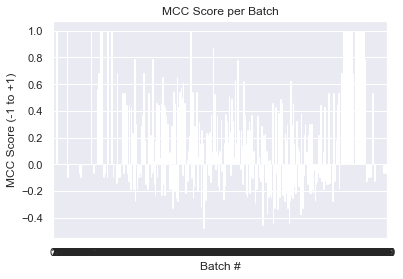

In [60]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [101]:
len(matthews_set)

3284

## Make new column for EPPI rankings

In [102]:
test_indeces=test_text.index
classifier_range=data['Classifier range'].to_numpy

In [103]:
def ranking_val(row):
    if row['Classifier range'] == '90-99% range' :
        return 95
    if row['Classifier range'] == '80-89% range' :
        return 85
    if row['Classifier range'] == '70-79% range' :
        return 75
    if row['Classifier range'] == '60-69% range' :
        return 65
    if row['Classifier range'] == '50-59% range' :
        return 55
    if row['Classifier range'] == '40-49% range' :
        return 45
    if row['Classifier range'] == '30-39% range' :
        return 35
    if row['Classifier range'] == '20-29% range' :
        return 25
    if row['Classifier range'] == '10-19% range' :
        return 15
    if row['Classifier range'] == '0-9% range' :
        return 5
    return 'Other'


In [104]:
data.apply (lambda row: ranking_val(row), axis=1)

0        95
1        95
2        95
3        95
4        95
         ..
53527     5
53528     5
53529     5
53530     5
53531     5
Length: 53532, dtype: int64

In [105]:
data['Eppi Ranking']=data.apply (lambda row: ranking_val(row), axis=1)

In [113]:
eppi_ranking=data['Eppi Ranking']
all_eppi_preds=eppi_ranking/100

In [114]:
eppi_preds = eppi_ranking[test_indeces]
eppi_preds= eppi_preds/100

In [115]:
test_y

tensor([1, 1, 1,  ..., 0, 0, 0])

In [116]:
len(true_labels)

3284

In [117]:
inclusion_probs

[array(1., dtype=float32),
 array(0.99, dtype=float32),
 array(0.99, dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0.72, dtype=float32),
 array(0.99, dtype=float32),
 array(0.98, dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(0.98, dtype=float32),
 array(1., dtype=float32),
 array(0.91, dtype=float32),
 array(0.96, dtype=float32),
 array(0.99, dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 array(1., dtype=float32),
 a

## ROC  AUC score

In [118]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(test_y, inclusion_probs)
eppi_roc_auc= roc_auc_score(test_y, eppi_preds)

print('Our ROC AUC score: ', roc_auc)
print('EPPI ROC AUC score: ', eppi_roc_auc)

Our ROC AUC score:  0.8194624901635125
EPPI ROC AUC score:  0.9072507920518817


In [119]:
print(test_y.shape)
print(len(inclusion_probs))
print(eppi_preds.shape)

torch.Size([52532])
52532
(52532,)


In [134]:
# inclusion_probs

In [120]:
test_array=np.asarray(test_y)

In [132]:
test_array

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [122]:
softmaxes

tensor([[0.0000, 1.0000],
        [0.0100, 0.9900],
        [0.0100, 0.9900],
        ...,
        [0.9800, 0.0200],
        [0.9800, 0.0200],
        [0.9700, 0.0300]])

<AxesSubplot:title={'center':'Test Our ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

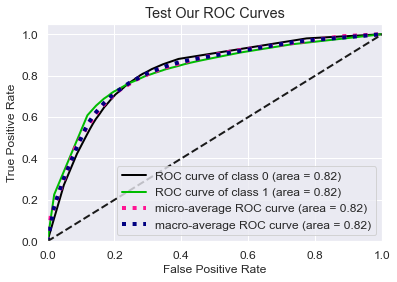

In [124]:
from scikitplot.metrics import plot_roc

fig, ax = plt.subplots()
plot_roc(test_array, softmaxes, title='Test Our ROC Curves', classes_to_plot=[0,1], ax=ax)


### plot_roc needs probabilities of all classes. Creating that for EPPI probs.

In [125]:
eppi_probs=np.empty((eppi_preds.shape[0],2))

In [126]:
eppi_probs.shape
eppi_probs[:,1]=eppi_preds
eppi_probs[:,0]=1-eppi_preds
print(eppi_probs)

[[0.05 0.95]
 [0.05 0.95]
 [0.05 0.95]
 ...
 [0.95 0.05]
 [0.95 0.05]
 [0.95 0.05]]


<AxesSubplot:title={'center':'Test EPPI ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

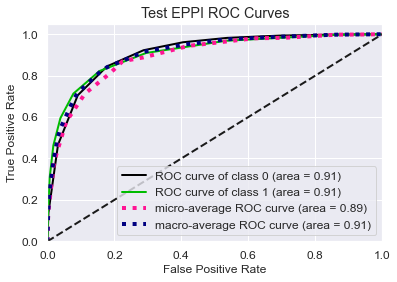

In [127]:
fig2, ax2=plt.subplots()
plot_roc(test_y, eppi_probs, ax=ax2, title='Test EPPI ROC Curves')

In [148]:
len(pred_flat_test)

52536

In [155]:
from sklearn.metrics import confusion_matrix

# y_pred_class =  > threshold
cm = confusion_matrix(test_labels, pred_flat_test)
tn, fp, fn, tp = cm.ravel()
print (cm)
print(classification_report(test_labels, pred_flat_test))

array([[18363,  6512],
       [ 6222, 21435]], dtype=int64)

In [156]:
print(classification_report(test_labels, pred_flat_test))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     24875
           1       0.77      0.78      0.77     27657

    accuracy                           0.76     52532
   macro avg       0.76      0.76      0.76     52532
weighted avg       0.76      0.76      0.76     52532



## Never before seen data

### Load data and get text column

In [30]:
file_path= 'input/combined_data_processed_new.xlsx'
new_data=pd.read_excel(file_path, engine='openpyxl')

for idx, row in new_data.iterrows():
    new_data.loc[idx,'text'] = str(row['title']) + '. ' + str(row['abstract'])
    
new_text= new_data['text']

In [34]:
new_data.shape

(1241, 16)

In [35]:
len(new_text)

1241

## Get tokenized sentences, seq, and mask

In [31]:
# tokenize and encode sequences in the test set
tokens_new = tokenizer.batch_encode_plus(
    new_text.tolist(),
    # max_length = 40,
    max_length = 360,
    padding='max_length',
    truncation=True
)

## convert lists to tensors

new_seq = torch.tensor(tokens_new['input_ids'])
new_mask = torch.tensor(tokens_new['attention_mask'])
#new_y = torch.tensor(test_labels.tolist(), dtype=torch.long) #no y values

In [32]:
#Create dataloader
prediction_data = TensorDataset(new_seq, 
                                new_mask)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=prediction_sampler, 
                                   batch_size=batch_size
                                  )

#input_ids= test_seq
#attention_masks= test_mask
#labels = test_y

## Predictions for new data

In [36]:
# Prediction on new data set

print('Predicting labels for {:,} new documents...'.format(len(new_seq)))

# Put model in evaluation mode
#model.eval() 
model.eval() #chamge from model.eval() to model1.eval() which we loaded 

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask  = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, #change to model1
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  #label_ids = b_labels.to('cpu').numpy() #no labels
  
  # Store predictions and true labels
  predictions.append(logits)
  #true_labels.append(label_ids) #no labels

print('    DONE.')

Predicting labels for 1,241 new sentences...
    DONE.


## Softmax

In [37]:
softmax_list=[]
for batch in predictions:
    x=nn.functional.softmax(torch.from_numpy(batch), dim=1)
    #print(x)
    softmax_list.append(x)

In [54]:
softmaxes=softmax_list[0]
for i in range(1,len(softmax_list)):
    softmaxes =torch.vstack((softmaxes, softmax_list[i]))

In [55]:
len(softmaxes)

1241

In [56]:
softmaxes

tensor([[0.9167, 0.0833],
        [0.9561, 0.0439],
        [0.7569, 0.2431],
        ...,
        [0.1328, 0.8672],
        [0.9370, 0.0630],
        [0.4418, 0.5582]])

In [63]:
inclusion_probs= []
for i in softmaxes:
    inclusion_probs.append(i[1].numpy())

In [65]:
len(inclusion_probs)

1241

In [66]:
new_data['Inclusion Ranking'] = inclusion_probs

In [67]:
new_data.columns

Index(['File', 'abstract', 'authors', 'doi', 'keywords', 'title', 'url',
       'year', 'identificators', 'countries_mentioned', 'country_codes',
       'provinces', 'districts', 'geo_regions', 'world_bankdivision_regions',
       'text', 'Inclusion Ranking'],
      dtype='object')

In [69]:
new_data['Inclusion Ranking']

0        0.08328079
1       0.043875206
2         0.2431417
3        0.97471106
4         0.9845069
           ...     
1236     0.22565475
1237      0.9423818
1238        0.86717
1239     0.06296131
1240      0.5581812
Name: Inclusion Ranking, Length: 1241, dtype: object

## Export excel with new text and Inclusion Ranking Columns

In [70]:
new_data.to_excel("ranking_output.xlsx")